# DeiT fine-tuning analysis

Import all necessary libraries and modules

In [36]:
# TODO (later): retain only what's necessary

import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torchvision
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from models_v2 import *
from scr_plots import *

Set global variables

In [88]:
RESULTS_DIR = "models/21_01_2025_18_00/"

LOG_PATH = RESULTS_DIR + "log.txt"
MODEL_PATH = RESULTS_DIR + "best_checkpoint.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#### Load log file

In [4]:
def read_log(log_path: str) -> pd.DataFrame:
    with open(log_path, "r") as f:
        lines = f.readlines()
    log_data = [json.loads(line) for line in lines]
    return pd.DataFrame(log_data)

In [5]:
read_log(LOG_PATH)

,train_lr,train_loss,test_loss,test_acc1,test_acc5,epoch,n_parameters
0,0.000001,5.034757,0.718526,82.548003,96.430002,0,4013416
1,0.000001,3.574236,0.734999,82.290003,96.260002,1,4013416
2,0.000101,2.344654,0.703127,81.652002,96.056003,2,4013416
3,0.000201,2.025807,0.717565,81.302003,95.946003,3,4013416
4,0.000300,1.938563,0.734037,80.796002,95.824003,4,4013416
5,0.000400,1.907937,0.744422,80.134002,95.716002,5,4013416
6,0.000255,1.824564,0.712913,80.968003,95.980003,6,4013416
7,0.000179,1.775066,0.695902,81.708003,96.076002,7,4013416
8,0.000111,1.732714,0.678040,82.004003,96.212003,8,4013416
9,0.000057,1.705318,0.668219,82.186002,96.272002,9,4013416


#### Load model

In [89]:
def load_model(model_path: str) -> nn.Module:
    model = torch.load(model_path, map_location=DEVICE)
    return model


In [90]:
model_dict = load_model(MODEL_PATH)

model = model_dict["model"]

/var/folders/cd/sr6rtt2j1rqdn0jdyblt3ztm0000gn/T/ipykernel_23730/3290159885.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=D

In [91]:
# instantiate a model with registers
ft_model = deit_small_patch16_LS_reg(pretrained=False, num_classes=1000)
# load a pretrained state dict containing register_tokens
ft_model.load_pretrained_state_dict(model_dict["model"])
ft_model = ft_model.to(DEVICE).eval()

number_of_registers = ft_model.register_tokens.shape[0]

>>>>>>>>>>>>>>>>>>>> NUMBER OF REGISTERS: 0
Loading 4 register tokens.


In [92]:
print("Registers shape: ", ft_model.register_tokens.shape, "\n")
print(ft_model)

Registers shape:  torch.Size([4, 384]) 

vit_models(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x Layer_scale_init_Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
  

## Initial visualization (TBD)

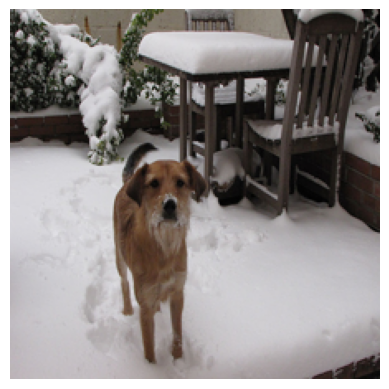

In [93]:
image_path = "./images/dog.JPEG"
img = get_image(image_path, img_shape=(224, 224)) # resize to 224x224!
plot_image(img.squeeze(0))

In [94]:
# final output shape
ft_model(img).shape

torch.Size([1, 1000])

In [140]:
def show_artifacts(
    test_model: nn.Module, test_image: torch.Tensor, log_scale=False, token: int = 0, shape: tuple = (24, 24), discard_tokens: int = 0, num_cols: int = 4, unfrozen_layers: int = 0
) -> None:
    """
    Generate the Attention maps and the norm values for the DEIT-III model

    test_model: DEIT-III model to be tested,
    test_image: Image of the correct size for the corresponding model, and batch dimension is accounted for
    log_scale: If True, the log of the attention map values will be displayed
    token: The token to be visualized in the attention maps
    """

    test_model(test_image)
    num_blocks = len(test_model.blocks)

    ## 1. Norm of feature values after MLP
    print("Norm of feature values after MLP")
    output = test_model.block_output[f"block{num_blocks-1}"]
    output = output.squeeze(0)
    # output = output[1:] # !!!!!!!!!!!
    # copmute norm of all output elements
    output_norms = output.norm(dim=-1)
    # output_norms.shape

    # TODO: double check
    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    #discard_tokens = 4 # discard the CLS token and 4 register tokens
    if discard_tokens > 0:
        cls = output_norms[0]
        registers = output_norms[-discard_tokens:]
        output_norms = output_norms[1:-discard_tokens]
    else:
        output_norms = output_norms[1:]
    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

    plt.imshow(output_norms.reshape(shape[0], shape[1]).detach().numpy())
    plt.axis("off")
    plt.colorbar(label="Norm Values")  # add a colorbar as a legend
    plt.show()

    print("Norm of register tokens: ", [round(float(x), 3) for x in registers.detach().numpy()])
    print('Norm of CLS token: ', (cls.detach().numpy()))

    plt.hist(output_norms.detach().numpy(), bins=50)
    plt.xlabel("Norm Values")
    plt.ylabel("Frequency")
    plt.show()

    
    #########################################################################################################

    ## 2. Attention maps for the last Attention Head
    # print("Attention maps for the last Attention Head")
    # attn_map_mean = (
    #     test_model.blocks[num_blocks - 1].attn.attn_map.squeeze(0).mean(dim=0)
    # )
    # ### !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    # if discard_tokens > 0:
    #     attn_map_mean = attn_map_mean[token][1:-discard_tokens]
    # else:
    #     attn_map_mean = attn_map_mean[token][1:]
    # if log_scale:
    #     attn_map_mean = torch.log(attn_map_mean + 1e-6)
    # # attn_map_mean.shape

    # plt.imshow(attn_map_mean.reshape(shape[0], shape[1]).detach().numpy())
    # plt.axis("off")
    # plt.colorbar(label="CLS attention map")
    # plt.show()
    #########################################################################################################

    ## 3. All attention maps
    print("All attention maps")

    num_rows = (
        num_blocks + num_cols - 1
    ) // num_cols  # calculate the number of rows needed
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 2.5))
    axes = axes.flatten()

    attn_reg = []

    for i in range(num_blocks):
        attn_map = test_model.blocks[i].attn.attn_map.squeeze(0).mean(dim=0)
        # attn_map = attn_map[token][1:] # !!!!!!!!!!!
        if discard_tokens > 0:
            attn_cls = attn_map[token][0]
            attn_reg.append(attn_map[token][-discard_tokens:])
            attn_map = attn_map[token][1:-discard_tokens]
        else:
            attn_cls = attn_map[token][0]
            attn_map = attn_map[token][1:]
        attn_map_img = attn_map.reshape(shape[0], shape[1]).detach().numpy()

        im = axes[i].imshow(attn_map_img)
        axes[i].axis("off")
        axes[i].set_title(f"Block {i+1}, CLS: {attn_cls:.3f}")
        fig.colorbar(im, ax=axes[i], orientation='vertical')

    # Hide any remaining empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

    if unfrozen_layers > 0:
        for i in list(range(unfrozen_layers))[::-1]:
            print("Attention of register tokens in block", num_blocks - i , "=", [round(float(x), 4) for x in attn_reg[num_blocks-1-i].detach().numpy()])
    print('\n')
    #########################################################################################################

    ## 4. All norm maps
    print("All norm maps")

    num_rows = (
        num_blocks + num_cols - 1
    ) // num_cols  # calculate the number of rows needed
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 2.5))
    axes = axes.flatten()
    output_norms_reg = []

    for i in range(num_blocks):
        output = test_model.block_output[f"block{i}"]
        output = output.squeeze(0)
        # output = output[1:] # !!!!!!!!!!!
        if discard_tokens > 0:
            output_cls = output[0]
            output_reg = output[-discard_tokens:]
            output = output[1:-discard_tokens]
        else:
            output_cls = output[0]
            output = output[1:]
        output_norms_cls = output_cls.norm(dim=-1)
        output_norms_reg.append(output_reg.norm(dim=-1))
        output_norms = output.norm(dim=-1)
        output_norms_img = output_norms.reshape(shape[0], shape[1]).detach().numpy()

        im = axes[i].imshow(output_norms_img)
        axes[i].axis("off")
        axes[i].set_title(f"Block {i+1}, cls = " + str(round(output_norms_cls.item(), 2)))
        fig.colorbar(im, ax=axes[i], orientation='vertical')

    # Hide any remaining empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

    #print(output_norms_reg)
    if unfrozen_layers > 0:
        for i in list(range(unfrozen_layers))[::-1]:
            print("Norm of register tokens in block", num_blocks - i , "=", [round(float(x), 3) for x in output_norms_reg[num_blocks-1-i].detach().numpy()])
    
        

Norm of feature values after MLP


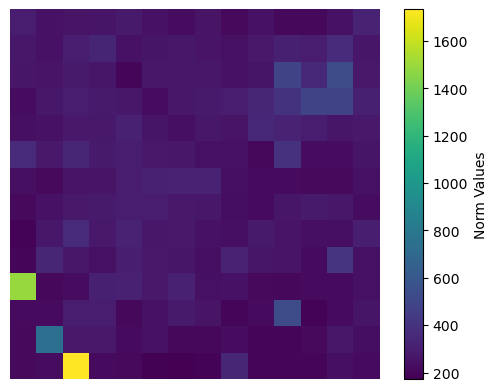

Norm of register tokens:  [429.896, 486.431, 428.724, 438.386]
Norm of CLS token:  275.34454


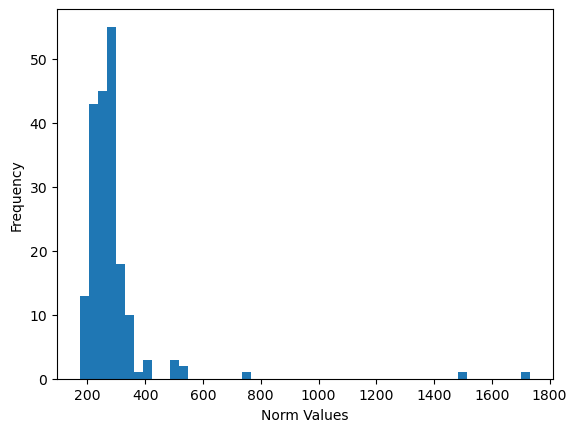

All attention maps


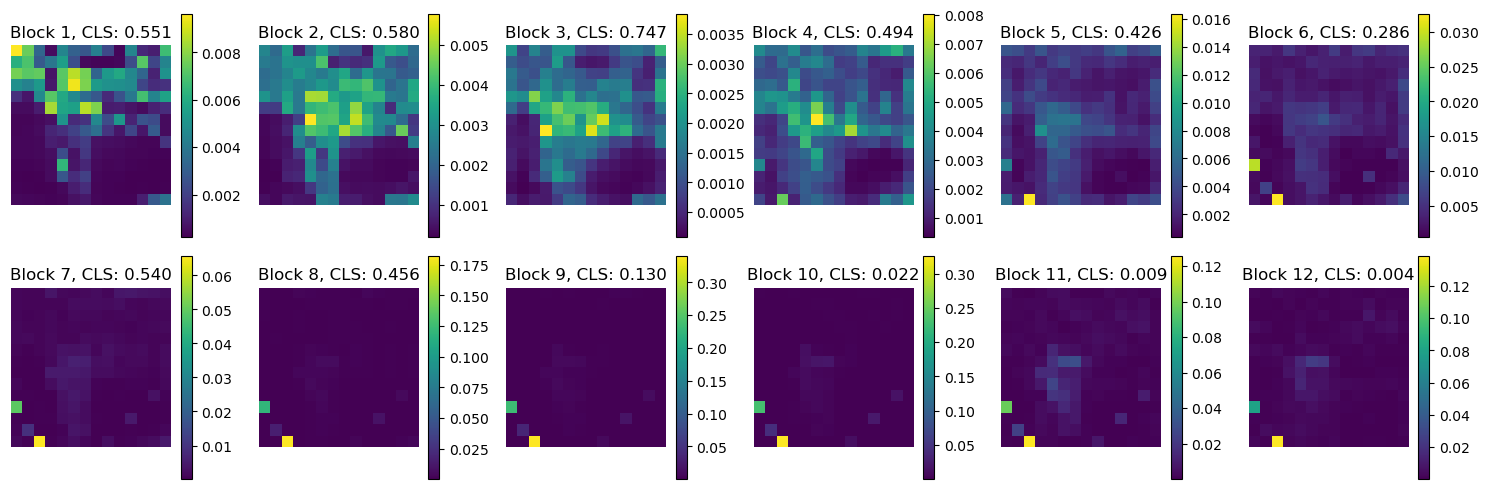

Attention of register tokens in block 11 = [0.0254, 0.0333, 0.0238, 0.0165]
Attention of register tokens in block 12 = [0.0624, 0.1026, 0.0688, 0.037]


All norm maps


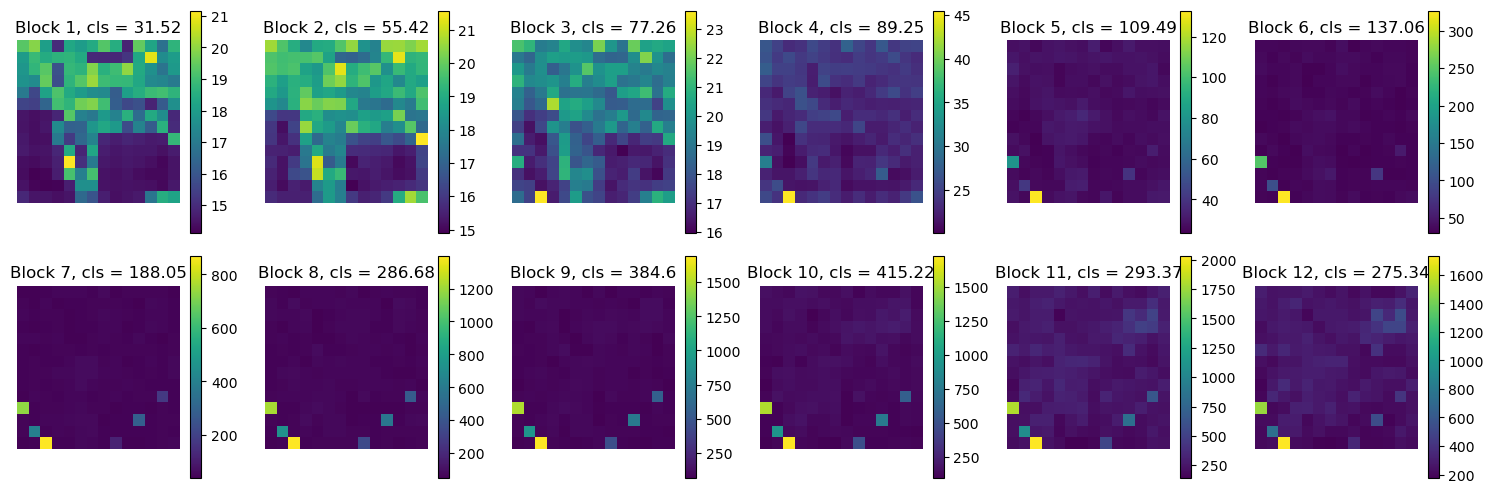

Norm of register tokens in block 11 = [610.684, 683.472, 608.567, 600.821]
Norm of register tokens in block 12 = [429.896, 486.431, 428.724, 438.386]


In [141]:
show_artifacts(ft_model, img, log_scale=True, token=0, shape=(14, 14), discard_tokens=number_of_registers, num_cols=6, unfrozen_layers=2)

### Top norm tokens vs. their attention values
Find the intersection of high-norm and high-attention tokens from a selected attention block (last by default) and visualize it

In [18]:
def top_norm_tokens(test_model: nn.Module, block: int = None, discard_tokens: int = number_of_registers ) -> np.ndarray:
    """Get sorted tokens with the highest norm values from the last block"""
    if block is None:
        block = len(test_model.blocks) - 1

    output = test_model.block_output["block" + str(block)]
    # output = output.squeeze(0)
    output = output[:, 1:-discard_tokens]  # discard the CLS token and 4 register tokens
    output_norms = output.norm(dim=-1)
    top_tokens = torch.argsort(output_norms, descending=True, dim=1)

    return top_tokens.cpu().numpy()


def top_attn_tokens(test_model: nn.Module, block: int = None, discard_tokens: int = number_of_registers) -> np.ndarray:
    """Get sorted tokens with the highest attention values from the last block"""
    if block is None:
        block = len(test_model.blocks) - 1
    attn_map_mean = test_model.blocks[block].attn.attn_map.mean(dim=1)
    top_tokens = torch.argsort(attn_map_mean[:, 0, 1:-discard_tokens], descending=True)
    return top_tokens.cpu().numpy()


def find_high_norm_attn_intersection(test_model: nn.Module, block: int = None, top_n: int = 10) -> np.ndarray:
    """Find the intersection of top tokens with the highest norm and attention values"""
    intersection = []
    top_norm = top_norm_tokens(test_model, block)[:, :top_n]
    top_attn = top_attn_tokens(test_model, block)[:, :top_n]

    for i in range(top_norm.shape[0]):
        intersection.append(np.intersect1d(top_attn[i], top_norm[i]))
    return intersection

In [19]:
chosen_model = ft_model
top10_attn_tokens = top_attn_tokens(chosen_model)[:, :10]
print(top10_attn_tokens)

top20_attn_tokens = top_attn_tokens(chosen_model)[:, :20]
print(top20_attn_tokens)

intersection = find_high_norm_attn_intersection(chosen_model)
print(intersection)

[[184 140  89  90 116  88 102 131 117  38]]
[[184 140  89  90 116  88 102 131 117  38 130 118 101 132  54 104 103 145
   34 115]]
[array([140, 184])]


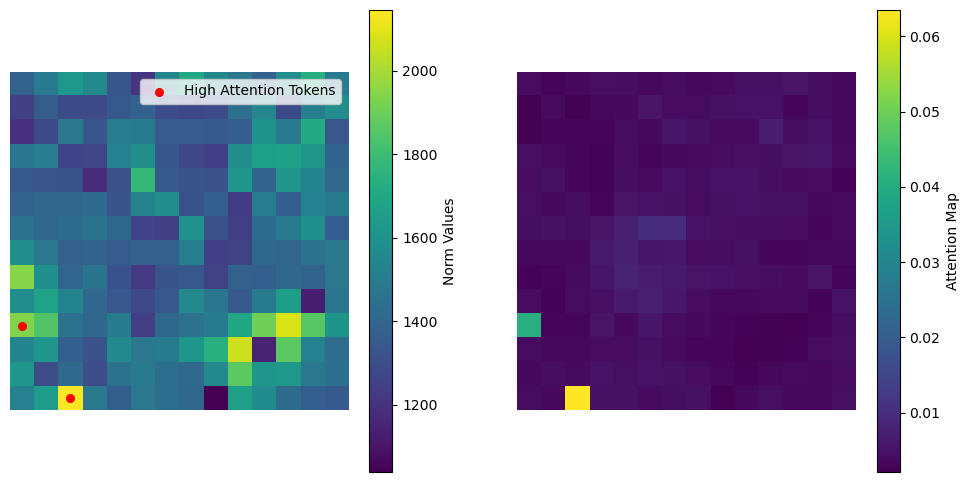

In [20]:
# NOTE: I think we should stick to the top 10/20 high-attention tokens, cause taking the intersection is kinda cheating 😬
plot_feature_norms_with_high_attn(
    chosen_model=chosen_model,
    output_tensor=chosen_model.block_output["block11"],
    high_attn_tokens=intersection,
    grid_size=(14, 14),
    discard_tokens=number_of_registers,
)

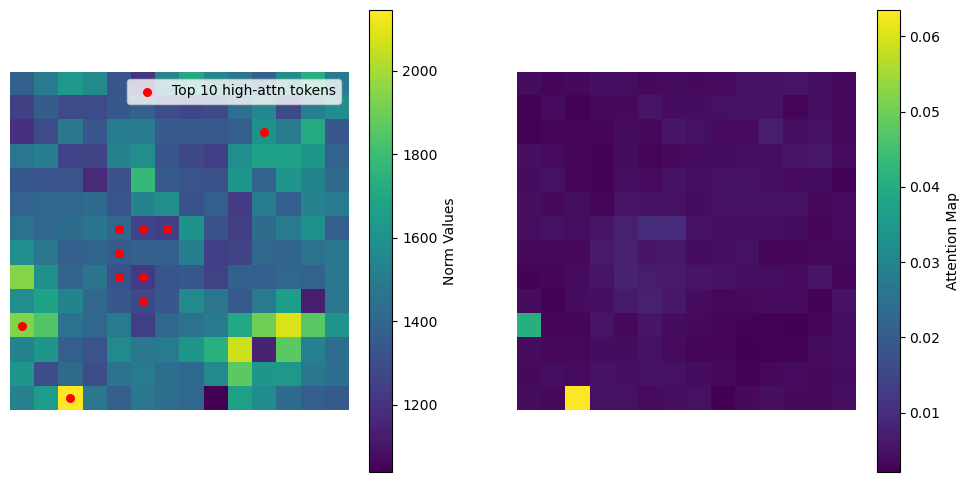

In [21]:
plot_feature_norms_with_high_attn(
    chosen_model=chosen_model,
    output_tensor=chosen_model.block_output["block11"],
    high_attn_tokens=top10_attn_tokens,
    label="Top 10 high-attn tokens",
    grid_size=(14, 14),
    discard_tokens=number_of_registers,
)

### Check attention values of selected tokens across all blocks

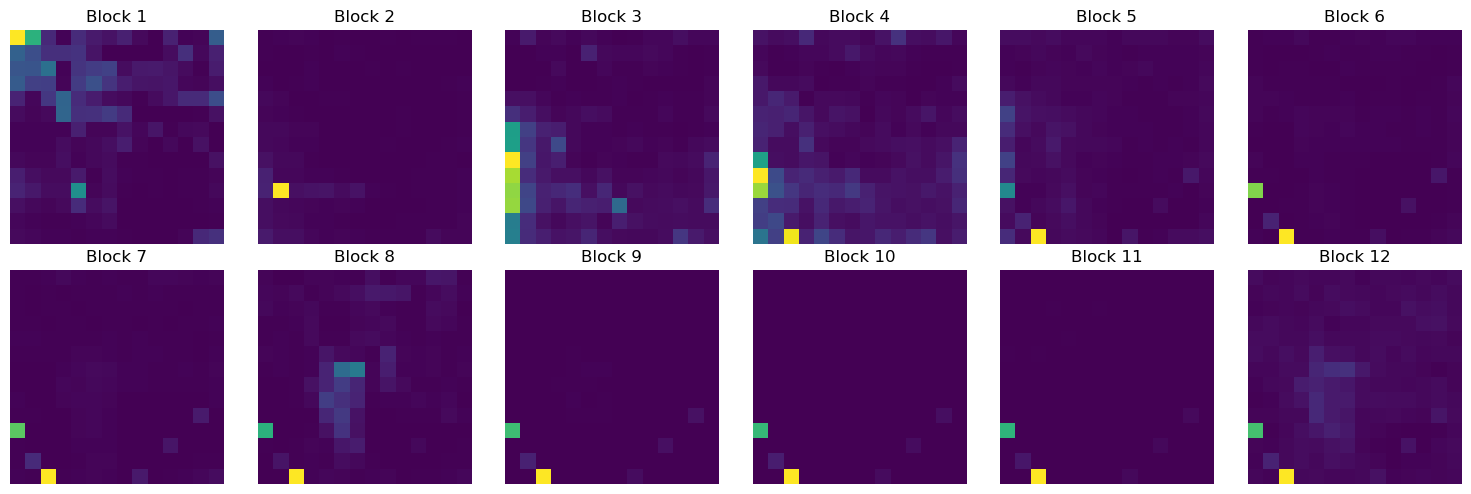

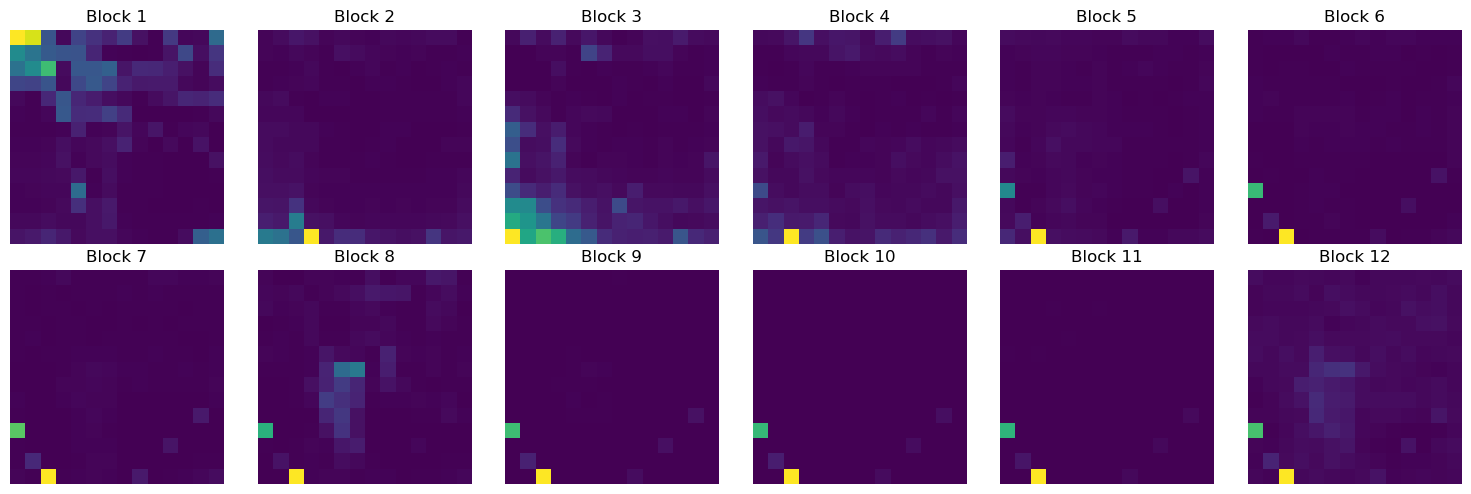

In [23]:
for x in intersection[0]:
    show_attn_progression(chosen_model, token = x, grid_size=(14, 14), discard_tokens=number_of_registers)

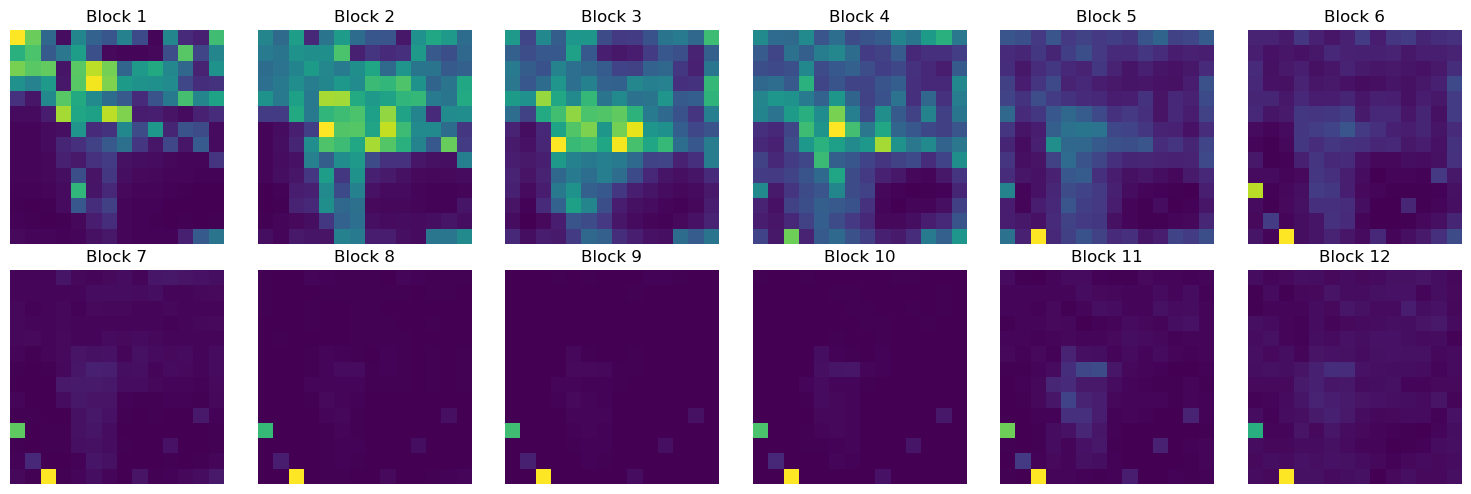

In [24]:
show_attn_progression(chosen_model, token = 'cls', grid_size=(14, 14), discard_tokens=number_of_registers)

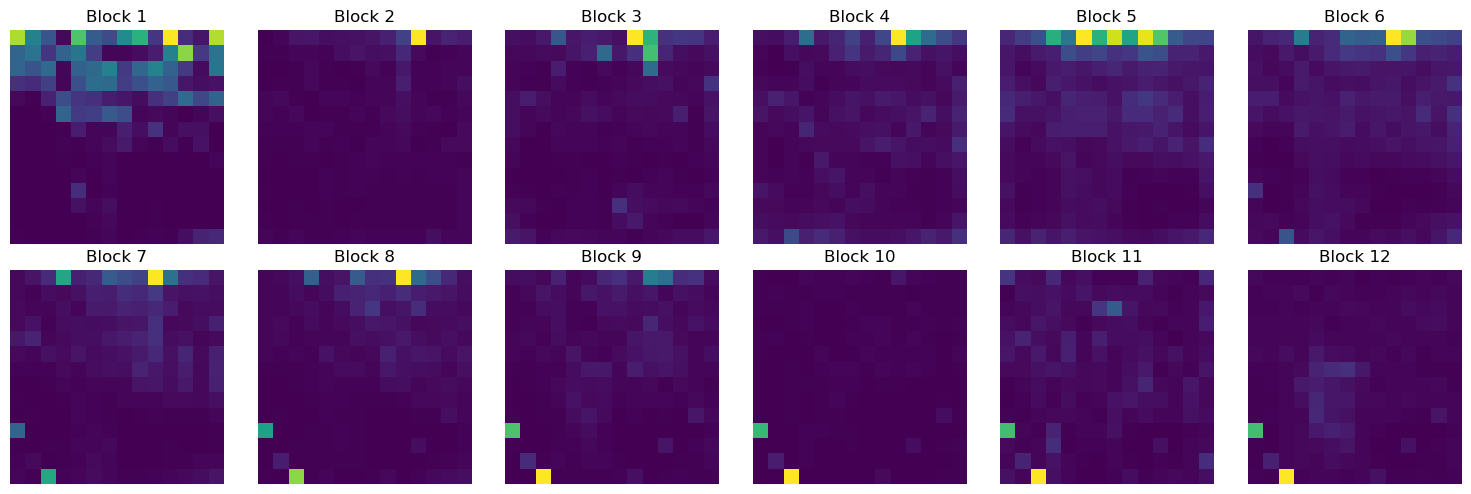

In [25]:
show_attn_progression(chosen_model, token = 9, grid_size=(14, 14), discard_tokens=number_of_registers)

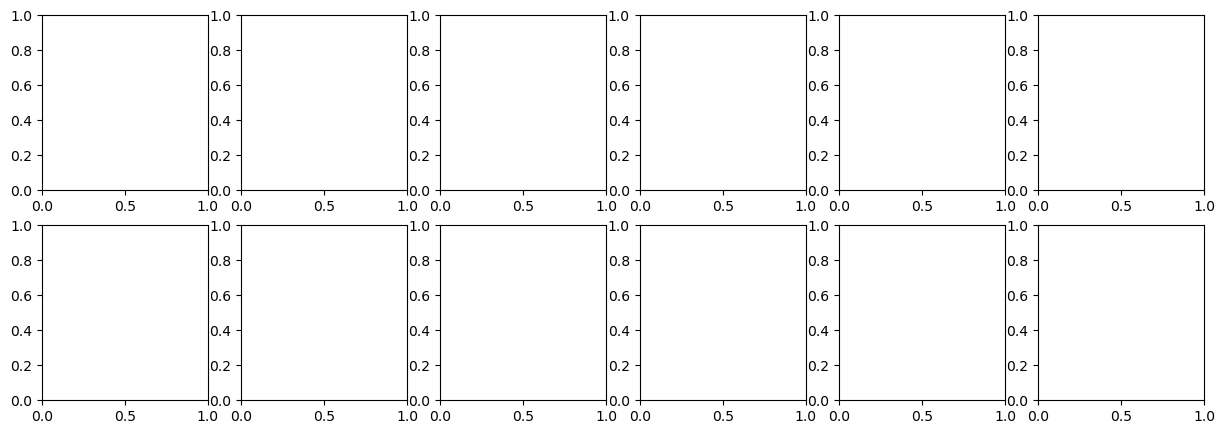

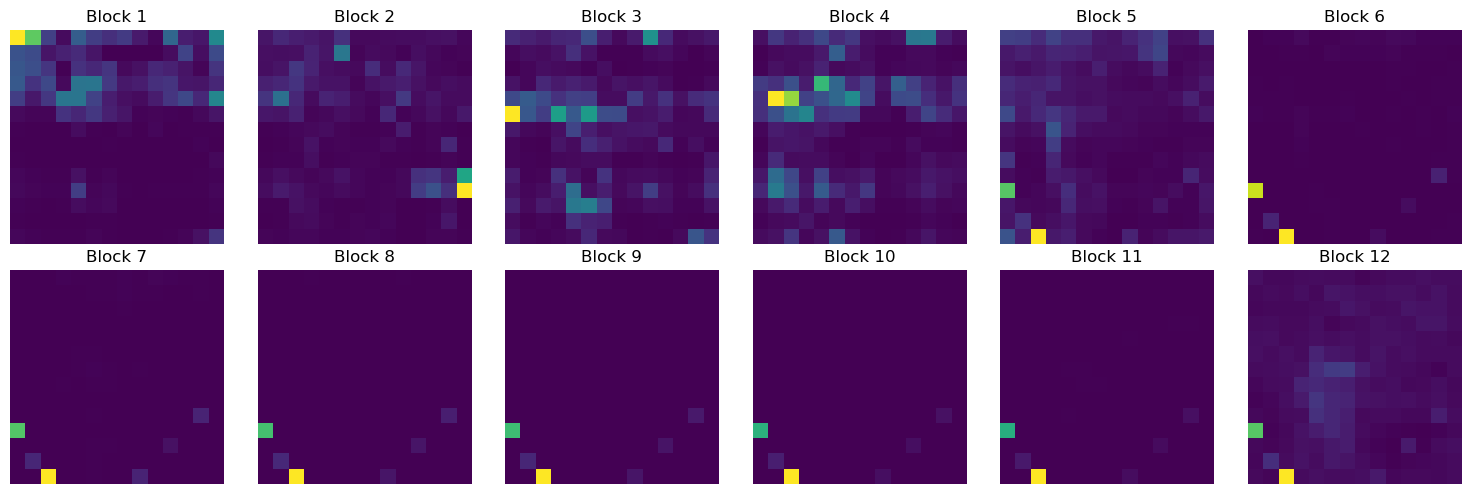

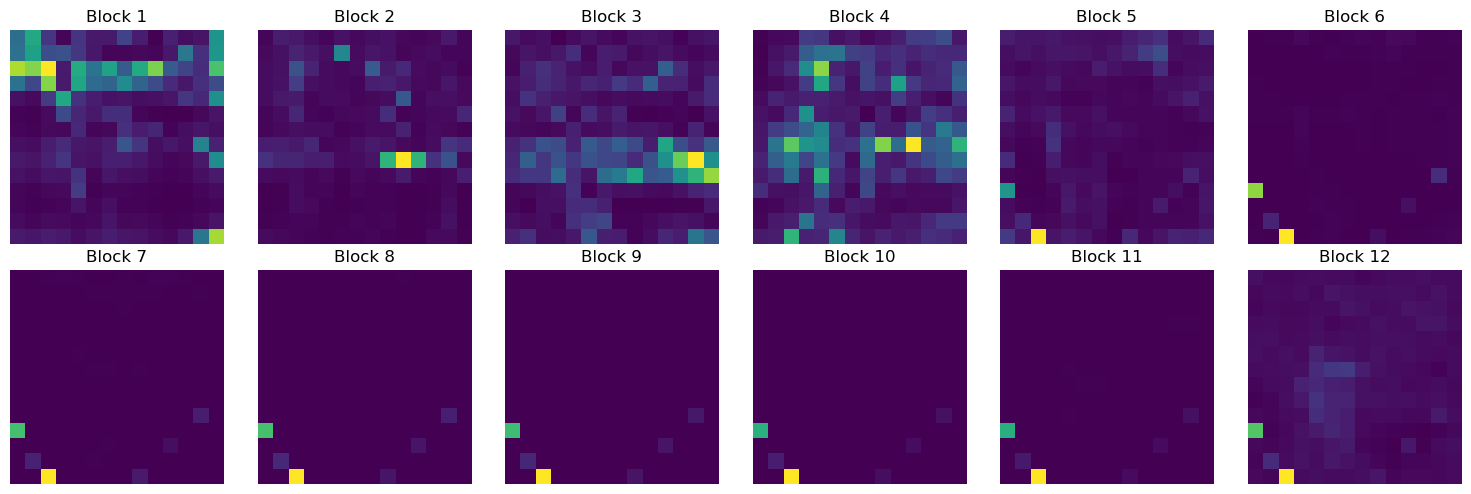

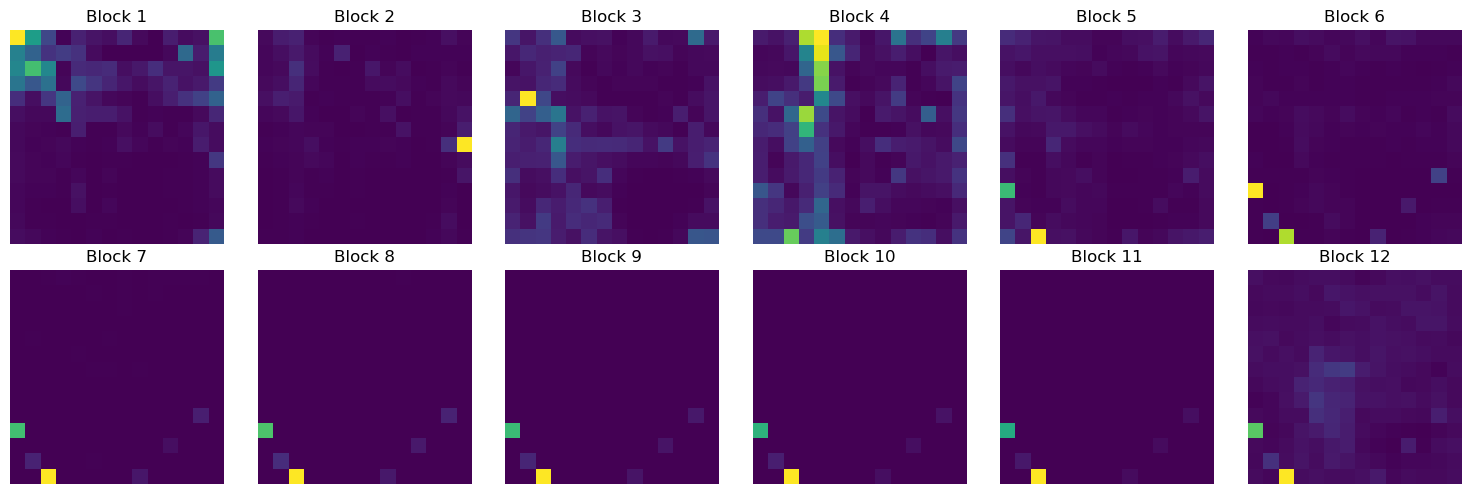

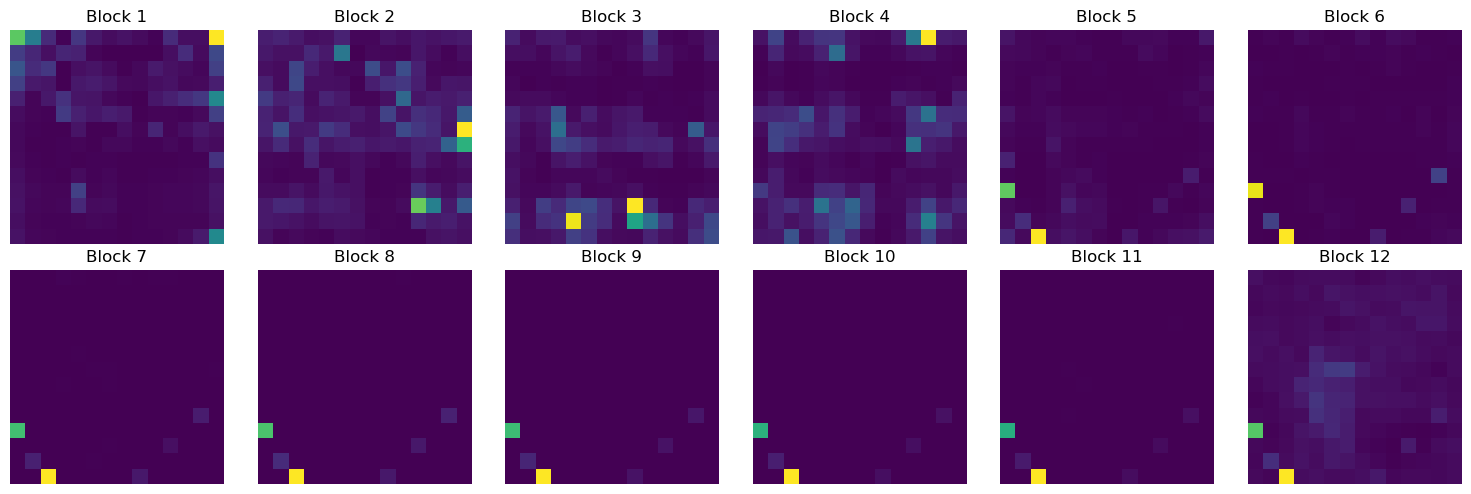

RuntimeError: shape '[14, 14]' is invalid for input of size 40401

In [26]:
show_attn_progression(chosen_model, token = 'reg', grid_size=(14, 14), discard_tokens=number_of_registers)

### Training logistic regression on high-norm and normal patches (CIFAR10)

In [19]:
# MAYBE TRAIN ON REGISTER TOKENS
use_mps = False
train_subset_size = 1500
test_subset_size = 400
batch_size = 16
image_size = 224
discard_tokens = number_of_registers

if use_mps:
    device = torch.device("mps")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [20]:
# logistic regression norm-normal

print("Loading CIFAR-10 dataset...")
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

print(f"Creating subsets: {train_subset_size} training images, {test_subset_size} testing images...")
train_indices = torch.randperm(len(train_dataset))[:train_subset_size]
test_indices = torch.randperm(len(test_dataset))[:test_subset_size]

train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
print("Subsets and DataLoaders ready.")

print(f"\nLoading model...")
model = chosen_model
model.to(device)
model.eval()
print(f"Model loaded and ready.")

Loading CIFAR-10 dataset...
Files already downloaded and verified
Files already downloaded and verified
Creating subsets: 1500 training images, 400 testing images...
Subsets and DataLoaders ready.

Loading model...
Model loaded and ready.


In [111]:
# Extract Patch Embeddings and Norms
high_norm_tokens = []
normal_tokens = []
labels_high = []  
labels_normal = [] 

print("Extracting patch embeddings...")
for batch_idx, (images, targets) in enumerate(train_loader):
    images = images.to(device)

    with torch.no_grad():
        model(images)
        # features = model.block_output['final']
        features = model.block_output['block11']
        
        patch_features = features[:, 1:-discard_tokens, :]  
        norms = torch.norm(patch_features, dim=-1).cpu().numpy()

        for i in range(images.size(0)):  
            single_patch_features = patch_features[i]
            single_norms = norms[i]

            single_norms_tensor = torch.tensor(single_norms)
            top_tokens = torch.argsort(single_norms_tensor, descending=True)[:10].numpy()
            high_indices = np.where(single_norms > single_norms[top_tokens[-1]])[0]
            normal_indices = np.where(single_norms <= single_norms[top_tokens[-1]])[0]

            if high_indices.size > 0:
                high_norm_token = single_patch_features[high_indices[np.random.randint(len(high_indices))], :].cpu().numpy()
                high_norm_tokens.append(high_norm_token)
                labels_high.append(targets[i].item())

            if normal_indices.size > 0:
                normal_token = single_patch_features[normal_indices[np.random.randint(len(normal_indices))], :].cpu().numpy()
                normal_tokens.append(normal_token)
                labels_normal.append(targets[i].item())
    
    print(f"Processed batch {batch_idx + 1}/{len(train_loader)}")

print("Patch embedding extraction complete.")

print("Preparing datasets for Logistic Regression...")
X_high = np.array(high_norm_tokens)
X_normal = np.array(normal_tokens)
y_high = np.array(labels_high)
y_normal = np.array(labels_normal)

print(len(X_high), len(X_normal))
print(len(y_high), len(y_normal))

print("Splitting data into training and testing sets...")
X_high_train, X_high_test, y_high_train, y_high_test = train_test_split(X_high, y_high, test_size=0.2, random_state=42)
X_normal_train, X_normal_test, y_normal_train, y_normal_test = train_test_split(X_normal, y_normal, test_size=0.2, random_state=42)

Extracting patch embeddings...
Processed batch 1/94
Processed batch 2/94
Processed batch 3/94
Processed batch 4/94
Processed batch 5/94
Processed batch 6/94
Processed batch 7/94
Processed batch 8/94
Processed batch 9/94
Processed batch 10/94
Processed batch 11/94
Processed batch 12/94
Processed batch 13/94
Processed batch 14/94
Processed batch 15/94
Processed batch 16/94
Processed batch 17/94
Processed batch 18/94
Processed batch 19/94
Processed batch 20/94
Processed batch 21/94
Processed batch 22/94
Processed batch 23/94
Processed batch 24/94
Processed batch 25/94
Processed batch 26/94
Processed batch 27/94
Processed batch 28/94
Processed batch 29/94
Processed batch 30/94
Processed batch 31/94
Processed batch 32/94
Processed batch 33/94
Processed batch 34/94
Processed batch 35/94
Processed batch 36/94
Processed batch 37/94
Processed batch 38/94
Processed batch 39/94
Processed batch 40/94
Processed batch 41/94
Processed batch 42/94
Processed batch 43/94
Processed batch 44/94
Processed 

In [113]:
print("Training Logistic Regression classifiers...")
clf_high = LogisticRegression(max_iter=10000).fit(X_high_train, y_high_train)
print("High-Norm Token classifier trained.")

clf_normal = LogisticRegression(max_iter=10000).fit(X_normal_train, y_normal_train)
print("Normal Token classifier trained.")

print("Evaluating classifiers...")
high_acc = accuracy_score(y_high_test, clf_high.predict(X_high_test))
normal_acc = accuracy_score(y_normal_test, clf_normal.predict(X_normal_test))

print(f"High-Norm Token Accuracy: {high_acc:.4f}")
print(f"Normal Token Accuracy: {normal_acc:.4f}")

Training Logistic Regression classifiers...
High-Norm Token classifier trained.
Normal Token classifier trained.
Evaluating classifiers...
High-Norm Token Accuracy: 0.6667
Normal Token Accuracy: 0.6100


### Cosine similarity between high-norm/normal patches and their neighbours

In [27]:
# NOTE: we base it on just one image, is it ok/reliable? (though in the paper they do it in the same manner I think, judging by the density values)
side = 14

chosen_model = chosen_model.to('cpu')
embedding = chosen_model.patch_embed(img).squeeze(0)
top_norm = top_norm_tokens(chosen_model)[0, :10]

In [28]:
all_tokens = dict()
for x in range(side * side):
    emb = embedding[x].detach()
    right = embedding[(x + 1) % (side * side)]
    left = embedding[x - 1]
    up = embedding[x - side]
    down = embedding[(x + side) % (side * side)]

    cos_sim = torch.nn.CosineSimilarity(dim=0)
    mean_sim = (
        cos_sim(emb, right) + cos_sim(emb, left) + cos_sim(emb, up) + cos_sim(emb, down)
    ) / 4

    all_tokens[x] = mean_sim.detach().numpy()

In [29]:
top_norm_keys = set(top_norm)
top_norm_similarities = [all_tokens[key] for key in top_norm_keys]

not_top_norm_keys = set(all_tokens.keys()) - top_norm_keys
not_top_norm_similarities = [all_tokens[key] for key in not_top_norm_keys]

top_norm_similarities = [float(similarity) for similarity in top_norm_similarities]
not_top_norm_similarities = [
    float(similarity) for similarity in not_top_norm_similarities
]

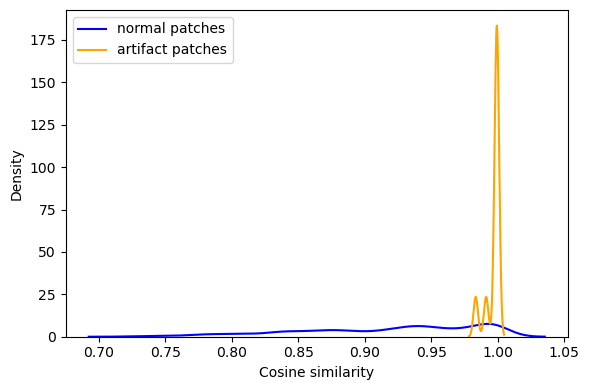

In [30]:
plot_similarity_density(top_norm_similarities, not_top_norm_similarities)

### training position

In [138]:
use_mps = True
side = 14
train_subset_size = 1500
batch_size = 16
image_size = 224
discard_tokens = number_of_registers

if use_mps:
    device = torch.device("mps")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: mps


In [125]:
from torch.utils.data import Subset, DataLoader
from torchvision import transforms
import torchvision

# logistic regression norm-normal 
print("Loading CIFAR-10 dataset...")
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

print(f"Creating subsets: {train_subset_size} training images, {test_subset_size} testing images...")
train_indices = torch.randperm(len(train_dataset))[:train_subset_size]
train_subset = Subset(train_dataset, train_indices)


batch_size = 16
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
print("Subsets and DataLoaders ready.")

print("Loading model...")
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = chosen_model
model.to(device)
model.eval()
print("Model loaded and ready.")

Loading CIFAR-10 dataset...
Files already downloaded and verified
Creating subsets: 1500 training images, 400 testing images...
Subsets and DataLoaders ready.
Loading model...
Model loaded and ready.


In [126]:
# put all elements of the train loader in a single ndarray
print("Extracting patch embeddings...")
patch_embeddings = dict()
patch_embeddings = dict()
artifact_indices = dict()
for batch_idx, (images, targets) in enumerate(train_loader):
    images = images.to(device)
    with torch.no_grad():
        chosen_model(images)
    for block in range(12):
        if block not in patch_embeddings:
            patch_embeddings[block] = []
        patch_embeddings[block].append(chosen_model.block_output[f'block{block}'][:,1:-discard_tokens,:].cpu().numpy())
        artifacts = find_high_norm_attn_intersection(chosen_model, block = block)

        for i in range(images.size(0)):
            if block not in artifact_indices:
                artifact_indices[block] = []
            artifact_indices[block].append(artifacts[i])
            

            
    print(f"Processed batch {batch_idx + 1}/{len(train_loader)}")

for block in range(12):
    patch_embeddings[block] = np.concatenate(patch_embeddings[block], axis=0)

print("Patch embeddings extracted.")


Extracting patch embeddings...
Processed batch 1/94
Processed batch 2/94
Processed batch 3/94
Processed batch 4/94
Processed batch 5/94
Processed batch 6/94
Processed batch 7/94
Processed batch 8/94
Processed batch 9/94
Processed batch 10/94
Processed batch 11/94
Processed batch 12/94
Processed batch 13/94
Processed batch 14/94
Processed batch 15/94
Processed batch 16/94
Processed batch 17/94
Processed batch 18/94
Processed batch 19/94
Processed batch 20/94
Processed batch 21/94
Processed batch 22/94
Processed batch 23/94
Processed batch 24/94
Processed batch 25/94
Processed batch 26/94
Processed batch 27/94
Processed batch 28/94
Processed batch 29/94
Processed batch 30/94
Processed batch 31/94
Processed batch 32/94
Processed batch 33/94
Processed batch 34/94
Processed batch 35/94
Processed batch 36/94
Processed batch 37/94
Processed batch 38/94
Processed batch 39/94
Processed batch 40/94
Processed batch 41/94
Processed batch 42/94
Processed batch 43/94
Processed batch 44/94
Processed 

In [139]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

y = np.array(range(side * side))
y = np.tile(y, train_subset_size)
X = patch_embeddings[block].reshape(-1, patch_embeddings[block].shape[-1])
indices = np.random.choice(X.shape[0], 10 * train_subset_size, replace=False)

for block in range(12):
    print(f"Training Linear Regression for block {block}...")
    X = patch_embeddings[block].reshape(-1, patch_embeddings[block].shape[-1])


    indices = np.random.choice(X.shape[0], 10000, replace=False)
    X_test = X[indices]
    y_test = y[indices]
    X_train = X[[index for index in range(X.shape[0]) if index not in indices]]
    y_train = y[[index for index in range(y.shape[0]) if index not in indices]]

    X_test_artifact = []
    y_test_artifact = []

    for index, x in enumerate(X_test):
        image_number = indices[index] // 576
        artifact_tokens = artifact_indices[block][image_number]
        if indices[index] % 576 in artifact_tokens:
            X_test_artifact.append(x)
            y_test_artifact.append(y_test[index])
        
    X_test_artifact = np.array(X_test_artifact)
    y_test_artifact = np.array(y_test_artifact)
    X_test_no_artifact = X_test[[index for index in range(X_test.shape[0]) if index not in indices]]
    y_test_no_artifact = y_test[[index for index in range(y_test.shape[0]) if index not in indices]]


    reg = LinearRegression().fit(X_train, y_train)

    y_pred_full = reg.predict(X_test)
    y_pred_artifact = reg.predict(X_test_artifact)
    y_pred_no_artifact = reg.predict(X_test_no_artifact)

    accuracy_full = np.mean(np.round(y_pred_full) == y_test)
    accuracy_artifact = np.mean(np.round(y_pred_artifact) == y_test_artifact)
    accuracy_no_artifact = np.mean(np.round(y_pred_no_artifact) == y_test_no_artifact)
    print(f"Block {block} Full Accuracy: {accuracy_full:.4f}, Artifact Accuracy: {accuracy_artifact:.4f}, No Artifact Accuracy: {accuracy_no_artifact:.4f}")



Training Linear Regression for block 0...
Block 0 Full Accuracy: 0.2851, Artifact Accuracy: 0.1875, No Artifact Accuracy: 0.2860
Training Linear Regression for block 1...
Block 1 Full Accuracy: 0.2324, Artifact Accuracy: 0.3382, No Artifact Accuracy: 0.2317
Training Linear Regression for block 2...
Block 2 Full Accuracy: 0.1974, Artifact Accuracy: 0.1429, No Artifact Accuracy: 0.1971
Training Linear Regression for block 3...
Block 3 Full Accuracy: 0.1559, Artifact Accuracy: 0.1806, No Artifact Accuracy: 0.1553
Training Linear Regression for block 4...
Block 4 Full Accuracy: 0.0726, Artifact Accuracy: 0.1111, No Artifact Accuracy: 0.0726
Training Linear Regression for block 5...
Block 5 Full Accuracy: 0.0314, Artifact Accuracy: 0.0312, No Artifact Accuracy: 0.0309
Training Linear Regression for block 6...
Block 6 Full Accuracy: 0.0165, Artifact Accuracy: 0.0265, No Artifact Accuracy: 0.0164
Training Linear Regression for block 7...
Block 7 Full Accuracy: 0.0082, Artifact Accuracy: 0.010

### Norm proportion across layers

In [31]:
use_mps = True
side = 14
train_subset_size = 100
batch_size = 16
image_size = 224
discard_tokens = number_of_registers
model = chosen_model

if use_mps:
    device = torch.device("mps")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: mps


In [32]:
print("Loading CIFAR-10 dataset...")
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


print(f"Creating subsets: {train_subset_size} training images...")
train_indices = torch.randperm(len(train_dataset))[:train_subset_size]

train_subset = Subset(train_dataset, train_indices)

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)

print("Subsets and DataLoaders ready.")

print("Loading model...")
model.to(device)
model.eval()
print("Model loaded and ready.")

Loading CIFAR-10 dataset...
Files already downloaded and verified
Creating subsets: 100 training images...
Subsets and DataLoaders ready.
Loading model...
Model loaded and ready.


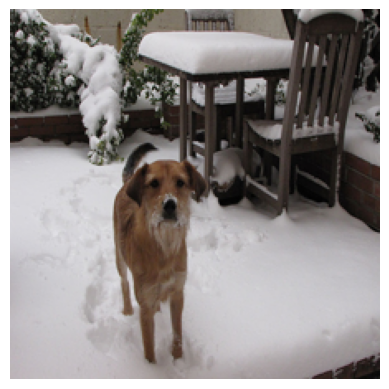

In [33]:
# either run this
# for images, targets in train_loader:
#     image = images[0]
#     break

# chosen_model(image.unsqueeze(0))
# plot_image(image)

################################################################################
# or this
chosen_model = chosen_model.to("cpu")
chosen_model(img)
plot_image(img.squeeze(0))

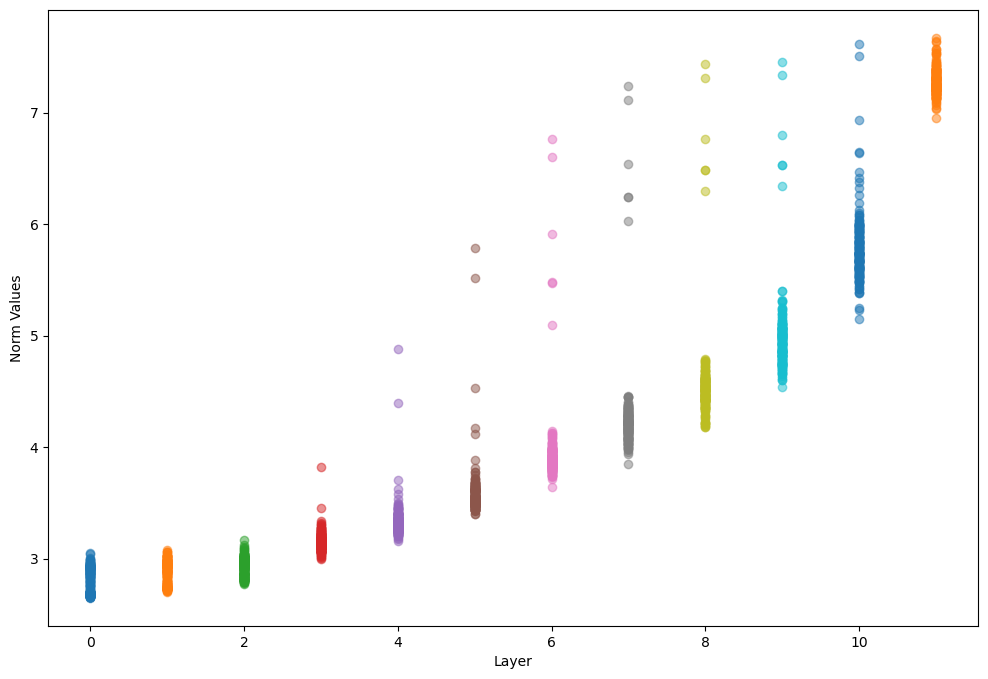

In [34]:
layer_norms = norm_per_layer(chosen_model = chosen_model, discard_tokens=number_of_registers)

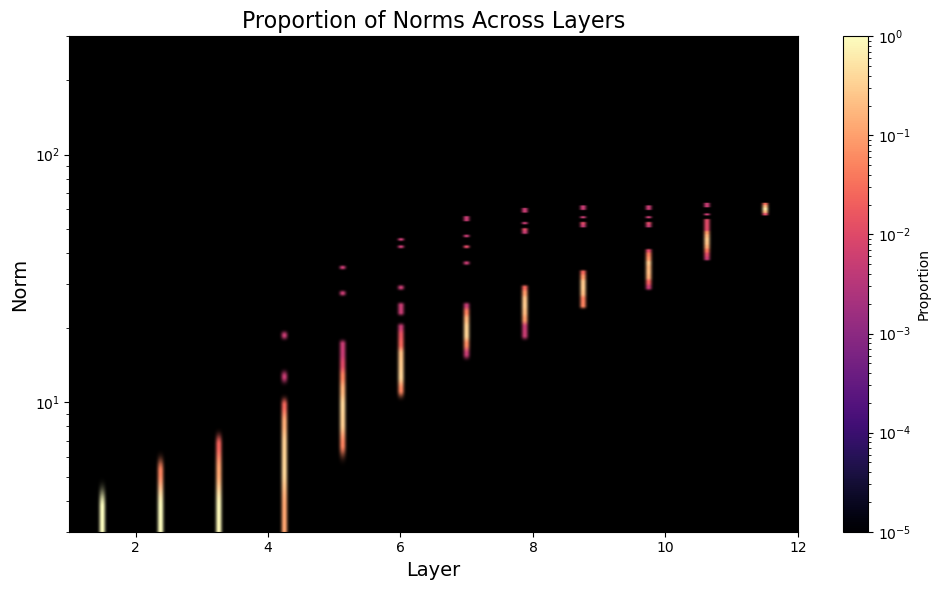

In [35]:
plot_norm_proportions(layer_norms)